In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [2]:
# Hyper parameter
# Maximum length of history to record
max_k = 5
# Learning rate
lr = 0.1
# Training epoch
epoch = 20
# Momentum
beta = 0.9

# Learnable parameter
# History length
k_s = 3
k_o = 3
# Greedy factor
g = torch.tensor(0.5, dtype=torch.float, requires_grad=True)
# Experience factor
e = torch.tensor(0.5, dtype=torch.float, requires_grad=True)

In [3]:
def GetInputString(input):
    if input == 0:
        return "rock"
    elif input == 1:
        return "paper"
    elif input == 2:
        return "scissor"

In [4]:
def GetPosterior_opponent(k, history):
    # Get last k choice
    his = history[-k:]
    
    # Likelihood with laplace smooth
    c_rock = history.count(his + str(0)) + 1
    c_paper = history.count(his + str(1)) + 1
    c_scissor = history.count(his + str(2)) + 1
    deno = c_rock + c_paper + c_scissor
    li = np.array([c_rock/deno, c_paper/deno, c_scissor/deno])
    #print("Likelihood: ", li)
    
    # Prior with laplace smooth
    c_all = len(history) + 3
    pr_rock = (history.count(str(0)) + 1)/c_all
    pr_paper = (history.count(str(1)) + 1)/c_all
    pr_scissor = (history.count(str(2)) + 1)/c_all
    pr = np.array([pr_rock, pr_paper, pr_scissor])
    # print("Prior: ", pr)
    
    # Posterior
    pos = (li*pr)/np.sum(li*pr)
    
    return pos

In [5]:
def GetPosterior_self(k, self_history, global_history):
    # Get last k choice
    his = global_history[-k*2:]
    
    # Likelihood with laplace smooth
    c_rock = global_history.count(his + str(0)) + 1
    c_paper = global_history.count(his + str(1)) + 1
    c_scissor = global_history.count(his + str(2)) + 1
    deno = c_rock + c_paper + c_scissor
    li = np.array([c_rock/deno, c_paper/deno, c_scissor/deno])
    #print("Likelihood: ", li)
    
    # Prior with laplace smooth
    c_all = len(self_history) + 3
    pr_rock = (self_history.count(str(0)) + 1)/c_all
    pr_paper = (self_history.count(str(1)) + 1)/c_all
    pr_scissor = (self_history.count(str(2)) + 1)/c_all
    pr = np.array([pr_rock, pr_paper, pr_scissor])
    #print("Prior: ", pr)
    
    # Posterior
    pos = (li*pr)/np.sum(li*pr)
    
    return pos

In [6]:
def RecordHistory(cpu_history, cpu_global_history, self_history, global_history, user_input, cpu_input):
    
    print("User input: ", GetInputString(user_input))
    print("CPU input: ", GetInputString(cpu_input))
    
    self_history += str(user_input)
    cpu_history += str(cpu_input)
    
    global_history += str(user_input)
    global_history += str(cpu_input)
    
    cpu_global_history += str(cpu_input)
    cpu_global_history += str(user_input)
    
    if any( [user_input == 0 and cpu_input == 0, user_input == 1 and cpu_input == 1, user_input == 2 and cpu_input == 2] ):
        print("Draw")
    elif any([user_input == 0 and cpu_input == 2, user_input == 1 and cpu_input == 0, user_input == 2 and cpu_input == 1]):
        print("Win")
    elif any([user_input == 0 and cpu_input == 1, user_input == 1 and cpu_input == 2, user_input == 2 and cpu_input == 0]):
        print("Lose")
        
    return cpu_history, cpu_global_history, self_history, global_history

In [7]:
def PosteriorCalculation(cpu_history, cpu_global_history, self_history, global_history, g, e, k_s, k_o):
    # Get the posterior
    p_o = GetPosterior_self(k_o, cpu_history, cpu_global_history)
    p_s = GetPosterior_self(k_s, self_history, global_history)
       
    r = (g*p_o[2] + (1-g)*p_o[0])*(1-e) + e*p_s[0]    
    p = (g*p_o[0] + (1-g)*p_o[1])*(1-e) + e*p_s[1]   
    s = (g*p_o[1] + (1-g)*p_o[2])*(1-e) + e*p_s[2]
    
    P = np.array([r, p, s])
    
    return P

In [8]:
def AlternativeVote(k_list, max_k):

    k_array = np.fliplr(np.array(k_list))

    countList = []
    entry = np.arange(1, 1+max_k, 1)

    for i in range(max_k - 1):
        countList = []
        for e in entry:
            countList.append(np.sum(k_array[:, 0] == e))

        min_index = np.argmin(countList)

        temp = np.zeros(k_array.shape[0])
        for i in range(0, k_array.shape[0]):
            for j in reversed(range(0, k_array.shape[1])):
                if k_array[i,j] != entry[min_index]:
                    temp[i] = k_array[i,j]
                    continue

        entry = np.delete(entry, min_index)
        
    return entry.item()

In [9]:
def UpdateParameters(lr, cpu_input, user_input, cpu_history, cpu_global_history, self_history, global_history, g, e, v_g, v_e):
    
    # For opponent k
    p_k_o = []
    for k_o in range(1, 6):
        p_k_o.append(GetPosterior_self(k_o, cpu_history, cpu_global_history)[cpu_input])
    
    k_index_o = np.argsort(np.asarray(p_k_o)) + 1
    k_o = k_index_o[0]
    
    #print(k_o)
    
    # For self k
    p_k = []
    for k in range(1, 6):
        p_k.append(PosteriorCalculation(cpu_history, cpu_global_history, self_history, global_history, g, e, k, k_o)[user_input])
    
    # Similar to Q learning, best reward
    p = np.max(np.asarray(p_k))
    # Sorted k index
    k_index = np.argsort(np.asarray(p_k)) + 1
    
    #print(k_index)

    
    nll = -user_input*torch.log(p)
    nll.backward()
    
    v_g = beta*v_g + (1-beta)*g.grad
    v_e = beta*v_e + (1-beta)*e.grad
    
    g.data -= lr*v_g
    e.data -= lr*v_e
    
    if g.data < 0.1:
        g.data = torch.tensor(0.1)
    elif g.data > 0.9:
        g.data = torch.tensor(0.9)
    
    if e.data < 0.1:
        e.data = torch.tensor(0.1)
    elif e.data > 0.9:
        e.data = torch.tensor(0.9)
    
    #print(g)
    #print(e)
    
    # Clear gradient
    g.grad.data.zero_()
    e.grad.data.zero_()
    
    return k_index, g, e, nll.data.numpy().item(), v_g, v_e

In [10]:
def GetUserInput():
    user_input = int(input("Rock 0, Paper 1 or Scissor 2? (stop 3) "))
    
    while(user_input != 0 and user_input != 1 and user_input != 2 and user_input != 3):
        user_input = int(input("Rock 0, Paper 1 or Scissor 2? (stop 3) "))
    
    return user_input

In [11]:
def GetCPUInput_train():
    cpu_rand = np.random.random_sample()
    if cpu_rand <= 1/3:
        cpu_input = 0
    elif cpu_rand <= 2/3:
        cpu_input = 1
    elif cpu_rand <= 1:
        cpu_input = 2
    
    return cpu_input

In [14]:
# History
# Online
cpu_history = ""
cpu_global_history = ""
# Datebase
self_history = ""
global_history = ""

In [15]:
v_g = torch.tensor(0.0)
v_e = torch.tensor(0.0)

print("Training...")
g_list = []
e_list = []
k_list = []

for i in range(epoch):
    print("===============================================================")
    print("Epoch: ", i)
    # Get user input
    user_input = GetUserInput()
    
    # Get cpu input
    cpu_input = GetCPUInput_train()
    
    if user_input == 3:
        print("Stop")
        break
    elif user_input == 0 or user_input == 1 or user_input == 2:
        k_index, g, e, nll, v_g, v_e = UpdateParameters(lr, cpu_input, user_input, cpu_history, cpu_global_history, self_history, global_history, g, e, v_g, v_e)

        cpu_history, cpu_global_history, self_history, global_history = RecordHistory(cpu_history, cpu_global_history, self_history, global_history, user_input, cpu_input)
        
        g_list.append(g.data.numpy().item())
        e_list.append(e.data.numpy().item())
        k_list.append(k_index)
        #print("loss: ", nll)

        
k_s = AlternativeVote(k_list, max_k)
        

Training...
Epoch:  0
Rock 0, Paper 1 or Scissor 2? (stop 3) 0
User input:  rock
CPU input:  paper
Lose
Epoch:  1
Rock 0, Paper 1 or Scissor 2? (stop 3) 0
User input:  rock
CPU input:  paper
Lose
Epoch:  2
Rock 0, Paper 1 or Scissor 2? (stop 3) 0
User input:  rock
CPU input:  rock
Draw
Epoch:  3
Rock 0, Paper 1 or Scissor 2? (stop 3) 2
User input:  scissor
CPU input:  paper
Win
Epoch:  4
Rock 0, Paper 1 or Scissor 2? (stop 3) 1
User input:  paper
CPU input:  paper
Draw
Epoch:  5
Rock 0, Paper 1 or Scissor 2? (stop 3) 0
User input:  rock
CPU input:  paper
Lose
Epoch:  6
Rock 0, Paper 1 or Scissor 2? (stop 3) 1
User input:  paper
CPU input:  paper
Draw
Epoch:  7
Rock 0, Paper 1 or Scissor 2? (stop 3) 0
User input:  rock
CPU input:  rock
Draw
Epoch:  8
Rock 0, Paper 1 or Scissor 2? (stop 3) 2
User input:  scissor
CPU input:  paper
Win
Epoch:  9
Rock 0, Paper 1 or Scissor 2? (stop 3) 2
User input:  scissor
CPU input:  scissor
Draw
Epoch:  10
Rock 0, Paper 1 or Scissor 2? (stop 3) 1
User in

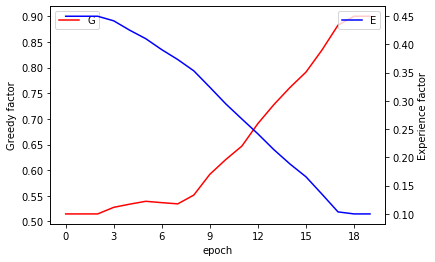

In [16]:
x_plot = np.arange(0, epoch, 1)
fig, ax1 = plt.subplots()
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xlabel('epoch')
ax1.set_ylabel('Greedy factor')
ax1.plot(x_plot, g_list, 'r')
ax2 = ax1.twinx()
ax2.set_ylabel('Experience factor')
ax2.plot(x_plot, e_list, 'b')

ax1.legend(('Greedy factor'))
ax2.legend(('Experience factor'))

In [17]:
print("Training results:")
print("k_s: ", k_s)
print("g: ", g.data.numpy())
print("e: ", e.data.numpy())

Training results:
k_s:  5
g:  0.9
e:  0.1


In [18]:
def UpdateParameters_test(cpu_input, cpu_history, cpu_global_history):
    
    # For opponent k
    p_k_o = []
    for k_o in range(1, 6):
        p_k_o.append(GetPosterior_self(k_o, cpu_history, cpu_global_history)[cpu_input])
    
    k_index_o = np.argsort(np.asarray(p_k_o)) + 1
    k_o = k_index_o[0]
    
    return k_o

In [19]:
# Clear opponent history
cpu_history = ""
cpu_global_history = ""
print("Testing...")

draw = 0
draw_rate = []

win = 0
win_rate = []

lose = 0
lose_rate = []

with torch.no_grad():
    for i in range(epoch):
        print("===============================================================")
        print("Epoch: ", i)
        
        #Get cpu input
        cpu_input = np.argmax(PosteriorCalculation(cpu_history, cpu_global_history, self_history, global_history, g, e, k_s, k_o))
        
        # Get and record user input
        user_input = GetUserInput()
        
        k_o = UpdateParameters_test(user_input, cpu_history, cpu_global_history)
        
        cpu_history += str(user_input)
        cpu_global_history += str(user_input)
        cpu_global_history += str(cpu_input)
        
        
        if user_input == 3:
            print("Stop")
            break
        elif user_input == 0 or user_input == 1 or user_input == 2:
            print("User input: ", GetInputString(user_input))
            print("CPU input: ", GetInputString(cpu_input))
            
            if any( [user_input == 0 and cpu_input == 0, user_input == 1 and cpu_input == 1, user_input == 2 and cpu_input == 2] ):
                print("Draw")
                draw += 1
            elif any([user_input == 0 and cpu_input == 2, user_input == 1 and cpu_input == 0, user_input == 2 and cpu_input == 1]):
                print("Win")
                win += 1
            elif any([user_input == 0 and cpu_input == 1, user_input == 1 and cpu_input == 2, user_input == 2 and cpu_input == 0]):
                print("Lose")
                lose += 1
                
            r_d = draw/(win + draw + lose)
            draw_rate.append(r_d)
            
            r_w = win/(win + draw + lose)
            win_rate.append(r_w)
            
            r_l = lose/(win + draw + lose)
            lose_rate.append(r_l)
        

Testing...
Epoch:  0
Rock 0, Paper 1 or Scissor 2? (stop 3) 0
User input:  rock
CPU input:  rock
Draw
Epoch:  1
Rock 0, Paper 1 or Scissor 2? (stop 3) 1
User input:  paper
CPU input:  paper
Draw
Epoch:  2
Rock 0, Paper 1 or Scissor 2? (stop 3) 2
User input:  scissor
CPU input:  paper
Win
Epoch:  3
Rock 0, Paper 1 or Scissor 2? (stop 3) 2
User input:  scissor
CPU input:  rock
Lose
Epoch:  4
Rock 0, Paper 1 or Scissor 2? (stop 3) 0
User input:  rock
CPU input:  rock
Draw
Epoch:  5
Rock 0, Paper 1 or Scissor 2? (stop 3) 1
User input:  paper
CPU input:  paper
Draw
Epoch:  6
Rock 0, Paper 1 or Scissor 2? (stop 3) 2
User input:  scissor
CPU input:  rock
Lose
Epoch:  7
Rock 0, Paper 1 or Scissor 2? (stop 3) 2
User input:  scissor
CPU input:  rock
Lose
Epoch:  8
Rock 0, Paper 1 or Scissor 2? (stop 3) 0
User input:  rock
CPU input:  rock
Draw
Epoch:  9
Rock 0, Paper 1 or Scissor 2? (stop 3) 2
User input:  scissor
CPU input:  scissor
Draw
Epoch:  10
Rock 0, Paper 1 or Scissor 2? (stop 3) 0
User 

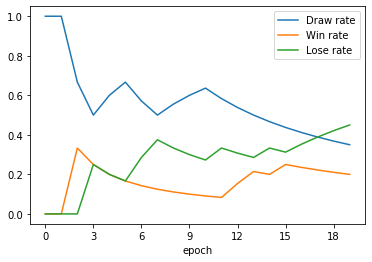

In [20]:
x_plot = np.arange(0, epoch, 1)
fig, ax1 = plt.subplots()
ax1.set_xlabel('epoch')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax1.plot(x_plot, draw_rate)
ax1.plot(x_plot, win_rate)
ax1.plot(x_plot, lose_rate)

plt.legend(('Draw rate', 'Win rate', 'Lose rate'),
           loc='upper right')